# **Componentes do grupo (matrícula e nome):**
1.  Eduardo Silvestre Pires Gonçalves (201703670) 
2.  Ricardo Ataide de Oliveira Junior (201703726)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data_utils


# **Apresentação do Problema**
A classificação de movimentos a partir de atividade eletromiográfica (EMG) é um problema clássico na Engenharia Biomédica e tem uma série de aplicações como o desenvolvimento de tecnologias assistivas.

Os dados que temos à disposição foram obtidos com o registro dos sinais EMG obtidos no antebraço com 8 eletrodos.  As ações a serem classificadas se encaixam em 7 casos distintos: um para cada um dos cinco dedos flexionados, um para repouso e o último para um gesto específico.

A sua tarefa é tentar classificar a ação executada como uma das 7 possíveis.

# **Obtenção e Visualização dos dados**

Raramente os sinais biológicos são usados na sua forma 'crua', tendo suas informações sintetizadas em uma série de características (desvio padrão, valor absoluto médio e outros). Para os dados com os quais vamos trabalhar, foram extraídas 10 características dos sinais de cada um dos 8 eletrodos.

Dessa forma, temos uma base de dados com 81 colunas: 10 características para cada eletrodo e a última coluna contendo o número da classe da ação registrada.

Cada linha da base de dados representa as informações de uma ação realizada.

Os dados estão disponíveis um arquivo CSV sem cabeçalho.


In [ ]:
#NÃO ALTERE ESTA CÉLULA
!gdown --id 1r8c6Qv3BiU_LNMSrvtex00lFbrut-Fnx
df = pd.read_csv('emg_features.csv', header=None)

Downloading...
From: https://drive.google.com/uc?id=1r8c6Qv3BiU_LNMSrvtex00lFbrut-Fnx
To: /content/emg_features.csv
100% 3.97M/3.97M [00:00<00:00, 14.7MB/s]


A próxima célula atribui nomes às colunas e mostras as informações básicas dos dados.

In [ ]:
#NÃO ALTERE ESTA CÉLULA
nClasses=7
header = []
for f in range(10):
    for i in range(8):
        header.append('c_'+str(f)+'_'+str(i))
header.append('label')
df.columns = header
pd.options.mode.use_inf_as_na = True
print(df.isnull().values.any())
print(len(df))


False
6823


Percebemos que não existe valores infinitos ou NaN (*Not a Number*). Caso existissem, você teria que tomar uma providência, uma vez que o nosso modelo trabalha apenas com números. As duas formas mais conhecidas são eliminar a linha com algum elemento nulo ou substituir pelo valor médio encontrado em outras entradas.

O próximo passo é verificar a distribuição de cada uma das colunas. Podemos agrupar esses dados por tipo, colocando os dados de vários eletrodos em um só gráfico de histograma.

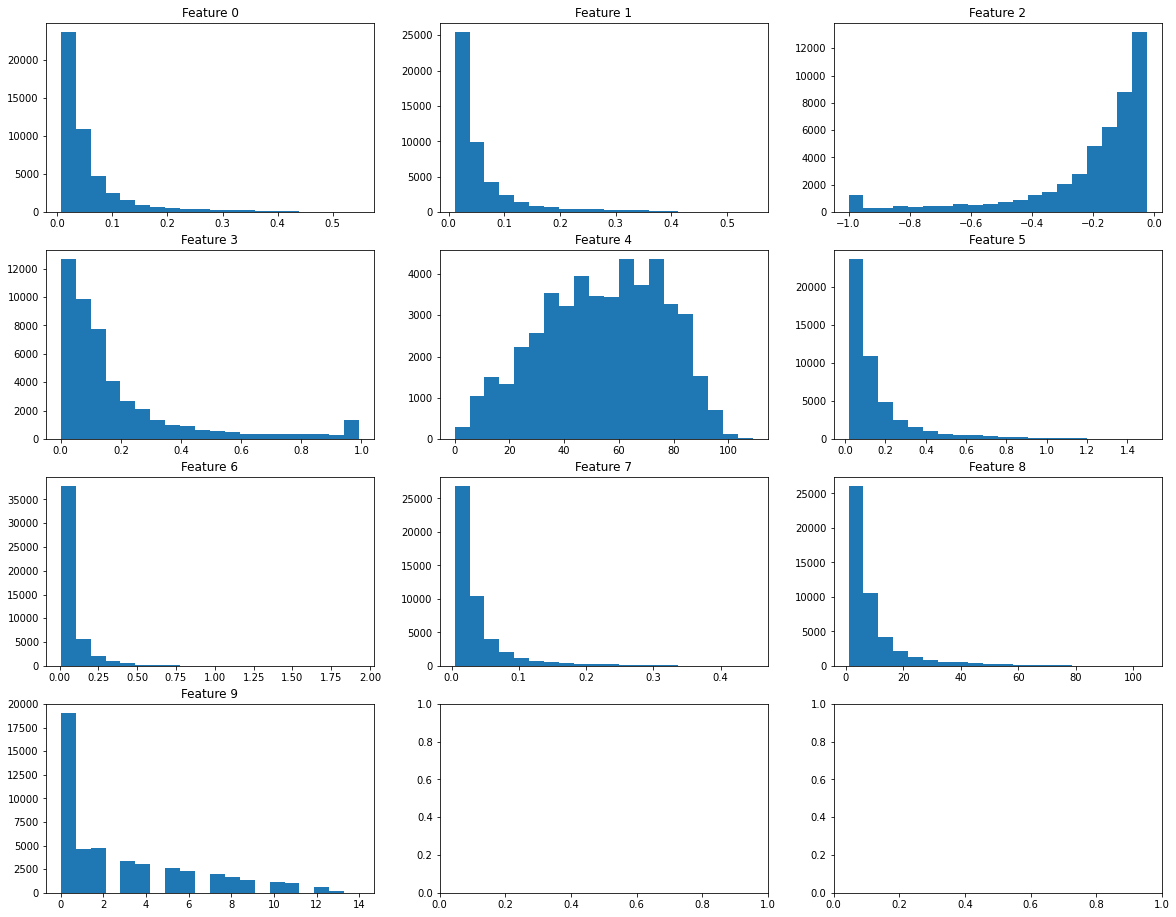

In [ ]:
#NÃO ALTERE ESTA CÉLULA
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,16))
for feature in range(10):
    line  =int(feature/3)
    column = int(feature%3)
    axes[line,column].hist(df.iloc[:,feature*8:-1+(feature+1)*8].values.reshape(-1),bins=20)
    axes[line,column].set_title('Feature ' + str(feature))

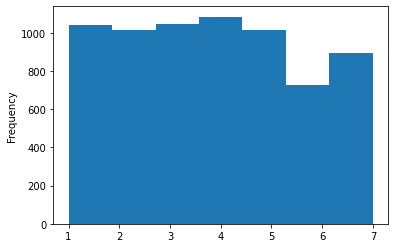

In [ ]:
#NÃO ALTERE ESTA CÉLULA
(df['label']).plot(kind='hist',bins=nClasses)

<h1 style='color: red; font-size: 19pt'><b>1. Parte da atividade na próxima célula</b></h1><img src='https://files.cercomp.ufg.br/weby/up/440/o/attention-307030_640.png' width=5%>

Ao observar os histogramas das características, percebemos que elas apresentam valores em faixas distintas. A segunda está em [-1;0] enquanto a quarta está em [0;100] e outras estão aproximadamente em [0;1].

Embora não seja obrigatório, é uma prática colocar todas as entradas de uma rede neural dentro de um mesmo intervalo, acelerando o algoritmo de gradiente descendente. Você pode ajustar para que todos fiquem entre [0;1] ou [-1;1] usando normalização min-max, por exemplo. Uma outra alternativa é fazer o z-score fazendo com que cada entrada tenha média zero e desvio padrão unitário.

Neste trabalho, você vai normalizar (cada coluna) pela média:


$\begin{align} 
x_{normalizado} = \frac{x-μ}{x_{max}-x_{min}}
\end{align}$

Lembre-se que a última coluna é a saída desejada e não deve ser normalizada. Porém, seus valores estão no intervalo [1;7] enquanto o Pytorch espera saídas desejadas começando em 0, para classificação. Você deve fazer o ajuste necessário.

Guarde o resultado em ***adjusted_df***.

In [ ]:
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ (max(x) - min(x)), axis=0)

aux_df = mean_norm(df)
aux_df["label"] = df["label"]
aux_df["label"] = aux_df["label"] - 1 

adjusted_df = aux_df
print(adjusted_df)



         c_0_0     c_0_1     c_0_2  ...     c_9_6     c_9_7  label
0    -0.037497 -0.034001 -0.017535  ... -0.236961 -0.186041      0
1    -0.018977 -0.096479 -0.150790  ... -0.236961 -0.114612      0
2     0.010409 -0.078322 -0.053779  ... -0.236961 -0.043184      0
3    -0.026825 -0.083533 -0.134048  ... -0.165533 -0.114612      0
4    -0.028722 -0.087068 -0.128660  ... -0.308390 -0.186041      0
...        ...       ...       ...  ...       ...       ...    ...
6818  0.156479  0.151677  0.591317  ...  0.620182  0.599673      6
6819  0.185588  0.162637  0.531551  ...  0.405896  0.599673      6
6820  0.154305  0.237588  0.497482  ...  0.620182  0.385388      6
6821  0.102154  0.191298  0.576028  ...  0.620182  0.599673      6
6822  0.193539  0.185479  0.675492  ...  0.405896  0.528245      6

[6823 rows x 81 columns]


Em seguida, vamos visualizar os histogramas dos dados ajustados. Usando a opção 'sharex=True', todos os gráficos terão os mesmos limites no eixo x e veremos que as características agora aparecem em intervalos similares.

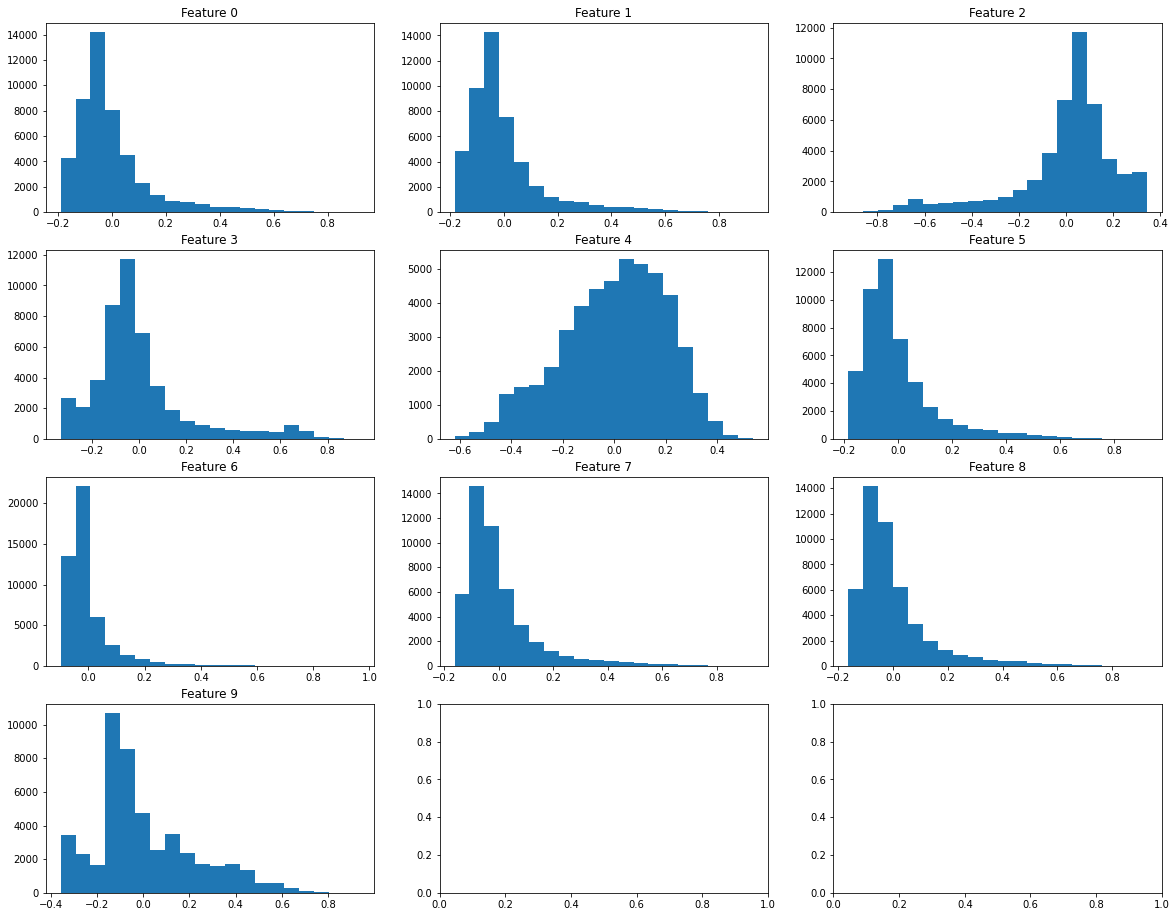

In [ ]:
#NÃO ALTERE ESTA CÉLULA
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,16))
for feature in range(10):
    line  =int(feature/3)
    column = int(feature%3)
    axes[line,column].hist(adjusted_df.iloc[:,feature*8:-1+(feature+1)*8].values.reshape(-1),bins=20)
    axes[line,column].set_title('Feature ' + str(feature))

Finalmente, certifique-se que a última coluna ainda mantém os valores esperados

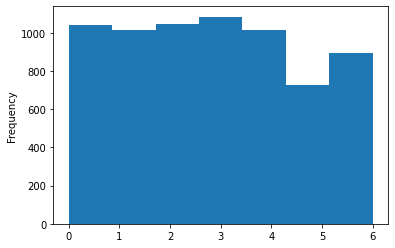

In [ ]:
#NÃO ALTERE ESTA CÉLULA
(adjusted_df['label']).plot(kind='hist',bins=nClasses); 


Percebemos que existe um equilíbrio entre as 5 primeiras classes (cerca de 14% do total de dados) enquanto a 6a. classe tem bem menos representantes (cerca de 10%). Contudo, isso não nos preocupa agora. A diferença não é absurda e existem dados suficientes para treinamento. Você verá no futuro que existem datasets bastante desbalanceados em que, por exemplo, trabalhamos com 3 classes e uma delas representa menos de 10% dos dados.

Em aprendizagem de máquina é comum uma etapa chamada análise exploratória de dados (EDA, no inglês). O que foi feito até agora é parte disso, em que buscamos lacunas nos dados, verificamos suas distribuições e fazemos a adequação dos intervalos. Mas existem outros aspectos de EDA, tais como a redução de dimensionalidade usando PCA (do inglês *Principal Component Analysis*), por exemplo.

# **Preparação dos Dataloaders**

<h1 style='color: red; font-size: 19pt'><b>2. Parte da atividade na próxima célula</b></h1><img src='https://files.cercomp.ufg.br/weby/up/440/o/attention-307030_640.png' width=5%>

Uma vez com os dados ajustados, vamos providenciar os mecanismos para apresentá-los ao modelo que vamos treinar e testar.

Você deverá:

1. Separar os dados nas partes de treinamento e teste. A variável **N_train** indica a quantidade de dados que serão usados no treinamento e está definida como 80% do total. Você pode alterar, se quiser.

2. Verificar, utilizando gráficos de histograma, que a distribuição de classes em cada grupo reflete algo muito próximo à distribuição do conjunto total de dados.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
N_train = int(0.8*len(df))
#COLOQUE O SEU CÓDIGO AQUI
train, test = train_test_split(adjusted_df, test_size=0.2)
print(train)
print(test)

         c_0_0     c_0_1     c_0_2  ...     c_9_6     c_9_7  label
4384 -0.046264 -0.080121 -0.126503  ... -0.308390 -0.186041      4
694  -0.012682 -0.030073 -0.028730  ... -0.094104  0.028245      0
2643 -0.092026 -0.067073 -0.112253  ...  0.334467 -0.186041      3
105   0.001763 -0.094248 -0.122346  ... -0.308390 -0.186041      0
21   -0.023364 -0.069212 -0.123481  ... -0.165533 -0.043184      0
...        ...       ...       ...  ...       ...       ...    ...
1603 -0.041074  0.077030 -0.121169  ...  0.548753  0.028245      2
2399 -0.089876 -0.132041 -0.177922  ...  0.048753 -0.114612      3
4688  0.251398  0.007744  0.251480  ...  0.405896 -0.186041      3
3028 -0.088100 -0.115067 -0.101675  ... -0.308390 -0.186041      4
5934 -0.009310 -0.022285 -0.087638  ...  0.405896  0.456816      2

[5458 rows x 81 columns]
         c_0_0     c_0_1     c_0_2  ...     c_9_6     c_9_7  label
2992 -0.078654 -0.098421 -0.119636  ... -0.308390 -0.186041      4
2830 -0.001734 -0.026121  0.094784  

(array([851., 809., 809., 875., 799., 596., 719.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

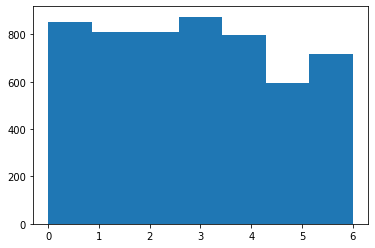

In [ ]:
plt.hist(train['label'].values,bins=nClasses) 


<h1 style='color: red; font-size: 19pt'><b>3. Parte da atividade na próxima célula</b></h1><img src='https://files.cercomp.ufg.br/weby/up/440/o/attention-307030_640.png' width=5%>

No próximo passo, você deverá criar os dadaloaders (torch.utils.data.TensorDataset) de treinamento e teste.

In [ ]:
batch_size = 32


x_train = train.iloc[:,0:80]
y_train =  train.iloc[:,80]
x_train = x_train.astype(np.float32)
x_train = torch.tensor(x_train.values)
y_train  = y_train .astype(np.int64)
y_train  = torch.tensor(y_train .values)
train_dataset = data_utils.TensorDataset(x_train, y_train)
train_dataloader = data_utils.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

x_test = test.iloc[:,0:80]
y_test =  test.iloc[:,80]
x_test = x_test.astype(np.float32)
x_test = torch.tensor(x_test.values)
y_test  = y_test.astype(np.int64)
y_test  = torch.tensor(y_test .values)
test_dataset = data_utils.TensorDataset(x_test, y_test)
test_dataloader = data_utils.DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

print(x_test)
print(y_test)

tensor([[-0.0787, -0.0984, -0.1196,  ..., -0.0853, -0.3084, -0.1860],
        [-0.0017, -0.0261,  0.0948,  ..., -0.1568, -0.3084, -0.1860],
        [-0.0508, -0.0573, -0.0674,  ..., -0.1568, -0.0227, -0.1860],
        ...,
        [-0.0850, -0.0168, -0.1603,  ..., -0.0853, -0.2370, -0.1860],
        [-0.0926, -0.0258, -0.1062,  ..., -0.1568, -0.3084, -0.1860],
        [ 0.0415, -0.0101,  0.0440,  ...,  0.0575,  0.3345,  0.5997]])
tensor([4, 3, 1,  ..., 1, 1, 6])


In [ ]:
for temp_x, temp_y in train_dataloader:
  print(temp_x)
  print(temp_y)
  print(temp_x.shape)
  print(temp_y.shape)

tensor([[-0.0935, -0.1204, -0.1597,  ..., -0.1568, -0.3084, -0.1860],
        [ 0.1241,  0.0653,  0.6257,  ..., -0.0853,  0.2630,  0.4568],
        [-0.0379,  0.0295, -0.0813,  ..., -0.0853, -0.1655, -0.1146],
        ...,
        [ 0.2090,  0.2520,  0.4341,  ...,  0.1290,  0.2630,  0.4568],
        [-0.0252,  0.1524, -0.1204,  ...,  0.0575,  0.2630, -0.1860],
        [-0.1088, -0.1373, -0.1739,  ..., -0.1568, -0.3084, -0.1860]])
tensor([5, 6, 1, 2, 4, 1, 1, 4, 2, 5, 6, 0, 1, 0, 5, 1, 4, 3, 6, 4, 2, 0, 1, 2,
        6, 2, 5, 2, 4, 6, 2, 5])
torch.Size([32, 80])
torch.Size([32])
tensor([[-0.0916, -0.0580, -0.1578,  ..., -0.0853, -0.3084, -0.1860],
        [ 0.0097, -0.0750, -0.1507,  ..., -0.1568, -0.3084, -0.1860],
        [ 0.0152,  0.0737,  0.1099,  ..., -0.0853,  0.4059,  0.5282],
        ...,
        [ 0.1286, -0.0038,  0.2935,  ...,  0.2004,  0.6202,  0.4568],
        [-0.0867, -0.1178, -0.1756,  ...,  0.3432,  0.1916, -0.1860],
        [-0.0869, -0.1342, -0.1735,  ..., -0.1568, -

Agora, vamos verificar se o dataloader de treinamento está funcionando

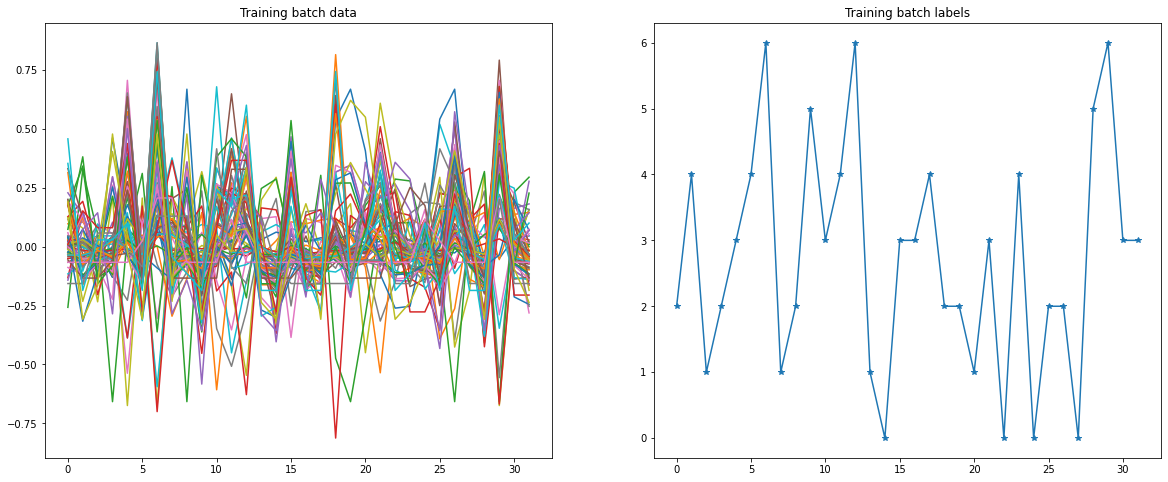

In [ ]:
#NÃO ALTERE ESTA CÉLULA
sample,target = next(iter(train_dataloader))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
axes[0].plot(sample.numpy())
axes[0].set_title('Training batch data')
axes[1].plot(target.numpy(),'-*')
axes[1].set_title('Training batch labels');

# **Determinando o modelo**

<h1 style='color: red; font-size: 19pt'><b>4. Parte da atividade na próxima célula</b></h1><img src='https://files.cercomp.ufg.br/weby/up/440/o/attention-307030_640.png' width=5%>

Neste ponto, você vai determinar a arquitetura do seu modelo. Não existe uma regra de ouro para a definição dos hiperparâmetros, e isso pode envolver algumas tentativas e erros.

Para evitar gastar muito tempo de processamento e arquiteturas muito complexas, defina o seu modelo dentro dos seguintes limites:
 - Camadas intermediárias: entre 2 e 5
 - Neurônios nas camadas intermediárias: máximo 50 em cada

In [ ]:

nInputs = 80
nOutputs = nClasses
#Perfection
# nHidden1 = 100
# nHidden2 = 80
# nHidden3 = 50
nHidden1 = 50
nHidden2 = 50
nHidden3 = 50
model = torch.nn.Sequential(
    #Camada de entrada
    torch.nn.Linear(nInputs, nHidden1),
    torch.nn.Tanh(),

    # #1º Camada Intermediaria
    torch.nn.Linear(nHidden1, nHidden2),
    torch.nn.Tanh(),

    #2º Camada Intermediaria
    torch.nn.Linear(nHidden2, nHidden3),
    torch.nn.Tanh(),


    #Camada de saída
    torch.nn.Linear(nHidden3, nOutputs),
 )  
print(model)



Sequential(
  (0): Linear(in_features=80, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): Tanh()
  (6): Linear(in_features=50, out_features=7, bias=True)
)


Antes de dar sequência no desenvolvimento, certifique-se de que, ao submeter entradas ao modelo, não ocorre um erro.

In [ ]:
#NÃO ALTERE ESTA CÉLULA

print(model(sample))
print(target)
print(model(sample).shape)
print(target.shape)

tensor([[-0.2487,  0.0977,  0.1856, -0.1018,  0.0484, -0.0489,  0.0779],
        [-0.2289,  0.0690,  0.2015, -0.0915,  0.0673, -0.0360,  0.0448],
        [-0.2462,  0.1077,  0.2112, -0.1113,  0.0587, -0.0382,  0.0623],
        [-0.2134,  0.1209,  0.1978, -0.1128,  0.0422, -0.0248,  0.0885],
        [-0.2457,  0.0643,  0.1827, -0.0292,  0.1100, -0.0161,  0.0898],
        [-0.2438,  0.0795,  0.2224, -0.1004,  0.0506, -0.0298,  0.0490],
        [-0.2666,  0.0837,  0.1611, -0.0260,  0.1139, -0.0226,  0.1011],
        [-0.2448,  0.0991,  0.2229, -0.0908,  0.0467, -0.0140,  0.0377],
        [-0.2046,  0.1183,  0.2015, -0.0936,  0.0504, -0.0116,  0.0924],
        [-0.2450,  0.0801,  0.2189, -0.1029,  0.0368, -0.0384,  0.0428],
        [-0.2055,  0.1084,  0.1891, -0.0655,  0.0622, -0.0306,  0.0870],
        [-0.2646,  0.0671,  0.1810, -0.0208,  0.0925, -0.0303,  0.0733],
        [-0.2699,  0.1036,  0.1821, -0.0983,  0.0913, -0.0526,  0.0857],
        [-0.2342,  0.0936,  0.2190, -0.1131,  0.058

In [ ]:
#NÃO ALTERE ESTA CÉLULA
if torch.cuda.is_available():
    model.cuda()
    print('Ueba! Vamos de GPU')
else:
    print('Ok. Vamos de CPU')

Ok. Vamos de CPU


<h1 style='color: red; font-size: 19pt'><b>5. Parte da atividade na próxima célula</b></h1><img src='https://files.cercomp.ufg.br/weby/up/440/o/attention-307030_640.png' width=5%>

Antes de providenciar o treinamento, você deverá definir:
- a taxa de aprendizagem
- o critério de erro
- o otimizador

In [ ]:

learningRate = 0.03
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate) 
# optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)   

# **Treinando o modelo**
<h1 style='color: red; font-size: 19pt'><b>6. Parte da atividade na próxima célula</b></h1><img src='https://files.cercomp.ufg.br/weby/up/440/o/attention-307030_640.png' width=5%>

Se tudo deu certo até agora, estamos prontos para treinar o modelo classificador.
Para isso, defina a função de treinamento que tem como argumento a quantidade de épocas e retorna uma lista com o erro de cada época.

In [ ]:
numEpochs = 10


In [ ]:
def train_model(nEpochs = numEpochs):
  errors=[]
  for epoch in range(nEpochs):
    for temp_x, temp_y in train_dataloader:
      if torch.cuda.is_available():
        inputs = torch.tensor(x_train).to('cuda')
        targets = torch.tensor(y_train).to('cuda')
      else:
        inputs = torch.tensor(x_train) 
        targets = torch.tensor(y_train)    
      # A linha abaixo zera os gradientes calculados anteriormente, para não acumular informações
      optimizer.zero_grad()
      # calculamos a saída da rede
      outputs = model(inputs)
      # calcula o erro
      loss = criterion(outputs, targets)
      # calcula os gradientes
      loss.backward()
      # atualiza parâmetros 
      optimizer.step()
      errors.append(loss.item())
      print('Epoch:' + str(epoch+1) + ' errors: ' + str(loss.item()))

  return errors

In [ ]:
#NÃO ALTERE ESTA CÉLULA A PARTIR DESTE PONTO
errors = train_model(numEpochs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Epoch:1 errors: 2.5793710847210605e-06
Epoch:1 errors: 2.5778203962545376e-06
Epoch:1 errors: 2.57640067502507e-06
Epoch:1 errors: 2.5750682652869727e-06
Epoch:1 errors: 2.573234041847172e-06
Epoch:1 errors: 2.571683580754325e-06
Epoch:1 errors: 2.5699146135593764e-06
Epoch:1 errors: 2.5683418698463356e-06
Epoch:1 errors: 2.566944203863386e-06
Epoch:1 errors: 2.5654151158960303e-06
Epoch:1 errors: 2.563733460192452e-06
Epoch:1 errors: 2.562073859735392e-06
Epoch:1 errors: 2.560392204031814e-06
Epoch:1 errors: 2.5589069991838187e-06
Epoch:1 errors: 2.557378365963814e-06
Epoch:1 errors: 2.555784021751606e-06
Epoch:1 errors: 2.5542331059114076e-06
Epoch:1 errors: 2.5527699563099304e-06
Epoch:1 errors: 2.5512413230899256e-06
Epoch:1 errors: 2.549406644902774e-06
Epoch:1 errors: 2.5480092062935e-06
Epoch:1 errors: 2.546611312936875e-06
Epoch:1 errors: 2.54512610808888e-06
Epoch:1 errors: 2.5436409032408847e-06
Epoch:1 errors: 2.5420683869015193e-06
Epoch:1 errors: 2.5404742700629868e-06
Epo

In [ ]:
print(model(sample))
print(model(sample).shape)
print(target)
print(target.shape)


tensor([[ -0.4639,   0.8525,  23.7417,   6.2075, -17.5592,  -8.4455,   3.2846],
        [  6.0541,  -7.6542, -16.6417,  -6.5664,  24.4835,   2.3977,  -8.6581],
        [  1.1136,  27.6296,   7.2791,  -2.0770,  -8.0196, -14.0244,  -3.4573],
        [  1.7354,   3.5076,  23.6385,   2.8923, -19.9612,  -6.6360,   1.4873],
        [-10.1017,  -0.2358, -13.1250,  27.4978,   0.4244,  -5.4635,   2.9669],
        [ -6.4586,  -0.9487, -14.7124,  -6.0761,  30.7944,  -0.5552,  -6.5684],
        [  0.0611,  -2.9516,   3.0473,   0.2053,   0.4264, -20.9573,  19.2237],
        [ -1.0610,  29.7857,   6.1182, -15.7409,  -0.2777,  -5.5169,  -8.7992],
        [  1.3946,   4.4220,  23.9796,   2.2477, -20.6798,  -7.4649,   2.4635],
        [  0.3649,   1.1774,  -9.2691,  -4.6925,   5.5296,  20.7397, -16.1992],
        [  3.0871,  -6.9871,  -1.1073,  23.0287,   3.6249,  -6.7868,  -7.6856],
        [  8.1444, -10.3264, -13.0194,  -5.9507,  19.8468,   1.9069,  -7.3584],
        [ -0.7640,  -2.2693,  -2.7278,  

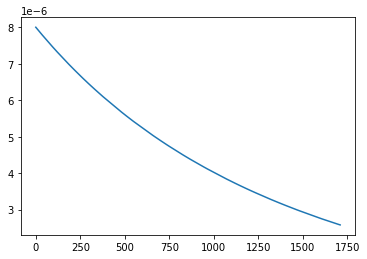

In [ ]:

#NÃO ALTERE ESTA CÉLULA
plt.plot(errors)

# **Testando o modelo**
<h1 style='color: red; font-size: 19pt'><b>7. Parte da atividade na próxima célula</b></h1><img src='https://files.cercomp.ufg.br/weby/up/440/o/attention-307030_640.png' width=5%>

Espera-se que o erro tenha caído consideravelmente após as primeiras épocas e, dependendo dos parâmetros, tenha ficado quase estabilizado, no final.

Agora, é necessário verificar a capacidade de generalização do modelo. 

Para isso vamos verificar como o modelo se comportou, em termos de classificação, para os dados de treinamento e teste. A ferramenta mais indicada para essa análise são a matriz de confusão e acurácia.

Você deverá criar uma função que:
- tem como entrada o dataloader, o modelo e número de Classes
- tem como saída a matriz de confusão e a acurácia

A <a href='https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826'> matriz de confusão</a> tem as dimensões $C$x$C$ onde $C$ é o número de classes. O seu elemento na posição $[i,j]$ apresenta a quantidade de elementos pertencentes à classe $i$ e que foram classificados como pertencentes à classe $j$.

In [ ]:
def createCM(loader,model,nClasses):
    from sklearn.metrics import confusion_matrix
    accuracy = 0
    CM = np.zeros((nClasses,nClasses))
    y_pred = []
    y_real = []
    #COLOQUE O SEU CÓDIGO AQUI
    with torch.no_grad():
       for inputs, targets in loader:
          outputs = model(inputs)
          y_pred.extend((torch.max(outputs,1)[1]).numpy())
          y_real.extend(targets.numpy())
    CM = confusion_matrix(y_real,y_pred)
    values_correctly = 0
    for l in range(0,nClasses):
        values_correctly += CM[l][l]
    accuracy = ((100/CM.sum()) * values_correctly)
    #Para cada classe  procura os valores do tensor que sao dessa classe, posteriormente compara com o 




    return CM, accuracy

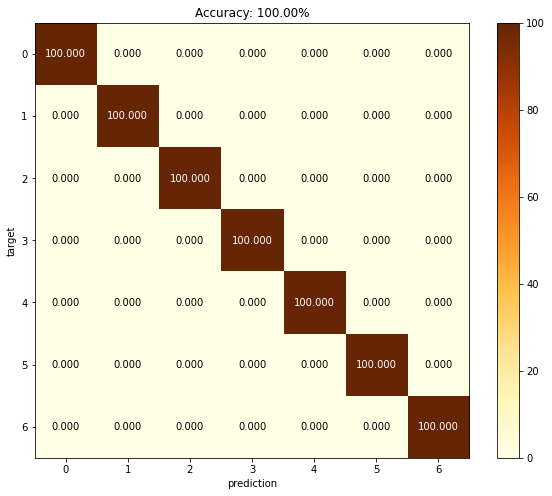

In [ ]:
#NÃO ALTERE ESTA CÉLULA
def plot_CM(CM,accuracy):
    CM = 100*CM/CM.sum(axis=1)
    plt.figure(figsize=(10,8))
    plt.imshow(CM,cmap='YlOrBr')
    plt.ylabel('target')
    plt.xlabel('prediction')
    plt.title('Accuracy: '+"{:4.2f}".format(accuracy)+'%')
    plt.colorbar()
    for i in range(CM.shape[0]):
        for j in range(CM.shape[1]):
            if CM[i,j]>70:
                color = "White"
            else:
                color = "Black"
            plt.text(j, i, "{:.3f}".format(CM[i,j]), ha="center", va="center", color=color)    

CM_train, accuracy_train = createCM(train_dataloader, model, nClasses)
plot_CM(CM_train, accuracy_train)

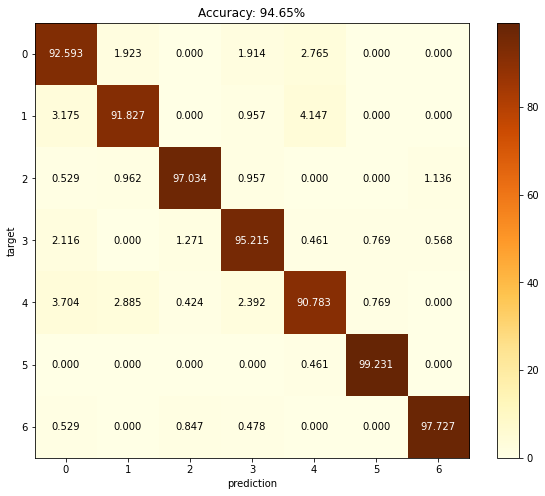

In [ ]:
#NÃO ALTERE ESTA CÉLULA
CM_test, accuracy_test = createCM(test_dataloader, model, 7)
plot_CM(CM_test, accuracy_test)

<h1 style='color: red; font-size: 19pt'><b>8. Parte da atividade nesta célula</b></h1><img src='https://files.cercomp.ufg.br/weby/up/440/o/attention-307030_640.png' width=5%>

Certifique-se de que a acurácia tenha sido maior que 89% nos dados de teste e 93% nos dados de treinamento.

Esses valores servem para certificar que você conseguiu um classificador com alguma qualidade. Para uma aplicação real, você poderia testar muitas variações mais complexas e com mais épocas e alcançar uma acurácia extremamente alta. nos perguntamos qual é um acerto aceitável. Obviamente, isso depende da aplicação.

Imagine que o seu modelo seja usado no controle de uma prótese de mão de uma pessoa amputada. Qual seria o acerto aceitável? Discutam e coloquem a reflexão a seguir.

---

**Resposta:**


A partir de pesquisas em material acadêmico, constatou-se a existência já em 2018 de acurácias acima de 99% em pesquisas realizadas por ALEFJOHN FEITOSA AMORIM na UFERSA. Como segue:

. Os sinais processados
foram classificados com o auxílio das Redes Neurais Artificiais, especificamente do tipo
multicamadas. As médias de acerto em relação aos movimentos abordados foram: 100 % para
mão aberta, 98,99 % para contração mão, 99,99 % para contração polegar e 98,74 % para
contração garra, resultando assim uma acurácia média de 99,43 %. 

Portanto, no caso apresentado, seria adequado o desenvolvimento de uma rede neural com mais accurácia, algo que poderia ser atingido refinando suas camadas e os hiperparâmetros, além da expansão dos conjuntos de dados para treinamento, validação e teste.